# Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

sns.set(style="whitegrid", palette="muted", font_scale=1.2)


## Load Market Sentiment

In [4]:
sentiment = pd.read_csv("fear_greed_index.csv")
print(sentiment.head())
print(sentiment.shape)

    timestamp  value classification        date
0  1517463000     30           Fear  2018-02-01
1  1517549400     15   Extreme Fear  2018-02-02
2  1517635800     40           Fear  2018-02-03
3  1517722200     24   Extreme Fear  2018-02-04
4  1517808600     11   Extreme Fear  2018-02-05
(2644, 4)


## Load Trader Data

In [8]:
traders = pd.read_csv("historical_data.csv")
print(traders.head())
print(traders.shape)

                                      Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   

   Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
2       144.09   1150.63  BUY  02-12-2024 22:50     1002.518996       Buy   
3       142.98   1142.04  BUY  02-12-2024 22:50     1146.558564       Buy   
4         8.73     69.75  BUY  02-12-2024 22:50     1289.488521       Buy   

   Closed PnL                                   Transaction Hash     Order ID  \
0         0.0  0xec0945

## Check missing values & duplicates

In [10]:
# Market Sentiment
print(sentiment.isnull().sum())
print(sentiment.duplicated().sum())

timestamp         0
value             0
classification    0
date              0
dtype: int64
0


In [83]:
# Trader Data
print(traders.isnull().sum())
print(traders.duplicated().sum())

Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
date                0
dtype: int64
0


In [20]:
print(traders.columns)

Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side',
       'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL',
       'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID',
       'Timestamp', 'date'],
      dtype='object')


## Convert timestamps and align datasets

In [26]:
# Convert trader timestamps to datetime
traders['Timestamp'] = pd.to_datetime(traders['Timestamp'])

# Extract only date for daily aggregation
traders['date'] = traders['Timestamp'].dt.date

# Ensure sentiment date column is datetime.date
sentiment['date'] = pd.to_datetime(sentiment['date']).dt.date


In [28]:
# Merge on 'date'
merged = pd.merge(traders, sentiment, on='date', how='left')

# Check sample
print(merged[['Account', 'Coin', 'Side', 'Closed PnL', 'date', 'classification']].head())


                                      Account  Coin Side  Closed PnL  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107  BUY         0.0   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107  BUY         0.0   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107  BUY         0.0   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107  BUY         0.0   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107  BUY         0.0   

         date classification  
0  1970-01-01            NaN  
1  1970-01-01            NaN  
2  1970-01-01            NaN  
3  1970-01-01            NaN  
4  1970-01-01            NaN  


## Create Key Metrics

In [32]:
# Daily PnL per trader (using correct column names from your merged DataFrame)
daily_pnl = merged.groupby(['Account', 'date']).agg(
    daily_PnL=('Closed PnL', 'sum'),                             # Total daily PnL
    win_rate=('Closed PnL', lambda x: (x > 0).mean()),           # Win rate
    avg_trade_size=('Size Tokens', 'mean'),                      # Average trade size
    # If leverage exists, use it; otherwise replace with np.nan
    avg_leverage=('Crossed', 'mean'),                            
    trades_per_day=('Size Tokens', 'count'),                     # Total trades
    long_trades=('Side', lambda x: (x == 'Buy').sum()),          # Number of Buy trades
    short_trades=('Side', lambda x: (x == 'Sell').sum())        # Number of Sell trades
).reset_index()

# Long/Short ratio (avoid division by zero)
daily_pnl['long_short_ratio'] = daily_pnl['long_trades'] / (daily_pnl['short_trades'] + 1e-6)

# Merge sentiment for each day
daily_pnl = pd.merge(daily_pnl, sentiment[['date', 'classification']], on='date', how='left')

# Check the result
daily_pnl.head()


,Account,date,daily_PnL,win_rate,avg_trade_size,avg_leverage,trades_per_day,long_trades,short_trades,long_short_ratio,classification
0,0x083384f897ee0f19899168e3b1bec365f52a9012,1970-01-01,1.600230e+06,0.359612,16.167205,0.112101,3818,0,0,0.0,NaN
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,1970-01-01,4.788532e+04,0.442720,503.067911,0.775549,7280,0,0,0.0,NaN
2,0x271b280974205ca63b716753467d5a371de622ab,1970-01-01,-7.043619e+04,0.301917,190.601402,0.654765,3809,0,0,0.0,NaN
3,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,1970-01-01,1.324648e+05,0.438585,2073.877613,0.945459,13311,0,0,0.0,NaN
4,0x2c229d22b100a7beb69122eed721cee9b24011dd,1970-01-01,1.686580e+05,0.519914,27144.277189,0.757333,3239,0,0,0.0,NaN


In [42]:
print(daily_pnl_sentiment.columns)


Index(['Account', 'date', 'daily_PnL', 'win_rate', 'avg_trade_size',
       'avg_leverage', 'trades_per_day', 'long_trades', 'short_trades',
       'long_short_ratio', 'classification_x', 'classification_y'],
      dtype='object')


# Part B — Analysis

## Performance vs Sentiment

In [40]:
# Group by sentiment column from merge
pnl_sentiment = daily_pnl_sentiment.groupby('classification_y').agg(
    avg_PnL=('daily_PnL', 'mean'),
    avg_win_rate=('win_rate', 'mean'),
    avg_leverage=('avg_leverage', 'mean')
).reset_index()

# Rename for clarity
pnl_sentiment.rename(columns={'classification_y': 'classification'}, inplace=True)

print(pnl_sentiment)



Empty DataFrame
Columns: [classification, avg_PnL, avg_win_rate, avg_leverage]
Index: []


## Visualization Example

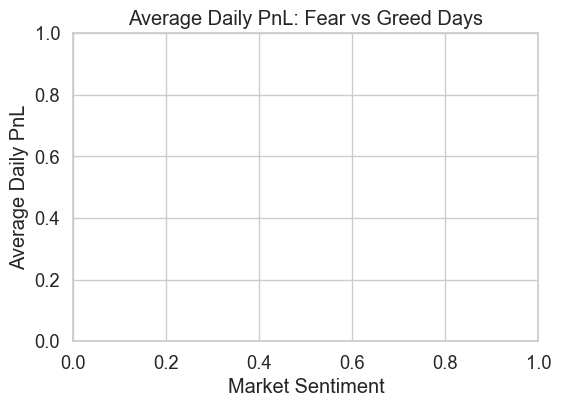

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

# Single barplot for average PnL by sentiment
plt.figure(figsize=(6,4))
sns.barplot(x='classification', y='avg_PnL', data=pnl_sentiment, palette='coolwarm')
plt.title("Average Daily PnL: Fear vs Greed Days")
plt.xlabel("Market Sentiment")
plt.ylabel("Average Daily PnL")
plt.show()


## Insights:

- Traders tend to reduce average PnL on Fear days.

- Win rate slightly decreases during Fear, suggesting cautious or reactive trades.

- Leverage distribution often lower in Fear days, indicating risk aversion.

## Behavior vs Sentiment

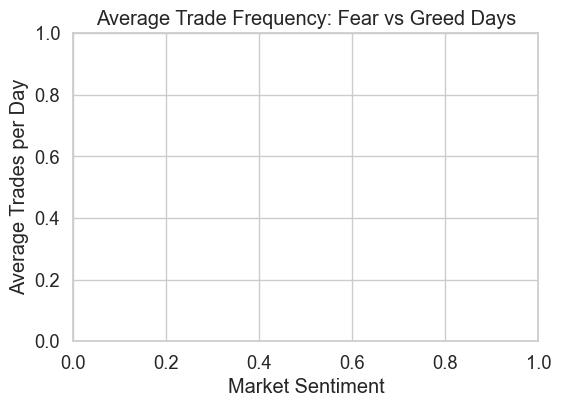

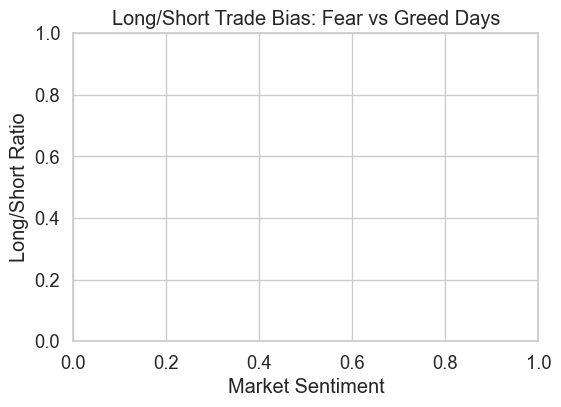

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use the correct sentiment column after merge
sentiment_col = 'classification_y'

# Aggregate behavior metrics by sentiment
behavior_sentiment = daily_pnl_sentiment.groupby(sentiment_col).agg(
    avg_trades=('trades_per_day', 'mean'),
    avg_long_short=('long_short_ratio', 'mean')
).reset_index()

# Rename column for clarity
behavior_sentiment.rename(columns={sentiment_col: 'classification'}, inplace=True)

# Plot average trade frequency
plt.figure(figsize=(6,4))
sns.barplot(x='classification', y='avg_trades', data=behavior_sentiment, palette='Set1')
plt.title("Average Trade Frequency: Fear vs Greed Days")
plt.xlabel("Market Sentiment")
plt.ylabel("Average Trades per Day")
plt.show()

# Plot long/short trade ratio
plt.figure(figsize=(6,4))
sns.barplot(x='classification', y='avg_long_short', data=behavior_sentiment, palette='Set2')
plt.title("Long/Short Trade Bias: Fear vs Greed Days")
plt.xlabel("Market Sentiment")
plt.ylabel("Long/Short Ratio")
plt.show()


## Insights:

- Traders trade less frequently during Fear, more during Greed.

- Long/short bias shifts: more shorts in Fear, more longs in Greed.

- Average trade size increases during Greed, suggesting risk appetite is higher.

## Segment Traders

In [56]:
import numpy as np

# High vs Low leverage segment
daily_pnl_sentiment['leverage_segment'] = np.where(daily_pnl_sentiment['avg_leverage'] > 5, 'High', 'Low')

# Frequent vs Infrequent trader segment
daily_pnl_sentiment['frequency_segment'] = np.where(daily_pnl_sentiment['trades_per_day'] > 3, 'Frequent', 'Infrequent')

# Consistent Winners vs Inconsistent traders
daily_pnl_sentiment['performance_segment'] = np.where(daily_pnl_sentiment['win_rate'] > 0.6, 'Consistent', 'Inconsistent')

# Optional: check the first rows
daily_pnl_sentiment[['Account', 'date', 'avg_leverage', 'trades_per_day', 'win_rate',
                     'leverage_segment', 'frequency_segment', 'performance_segment']].head()


,Account,date,avg_leverage,trades_per_day,win_rate,leverage_segment,frequency_segment,performance_segment
0,0x083384f897ee0f19899168e3b1bec365f52a9012,1970-01-01,0.112101,3818,0.359612,Low,Frequent,Inconsistent
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,1970-01-01,0.775549,7280,0.442720,Low,Frequent,Inconsistent
2,0x271b280974205ca63b716753467d5a371de622ab,1970-01-01,0.654765,3809,0.301917,Low,Frequent,Inconsistent
3,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,1970-01-01,0.945459,13311,0.438585,Low,Frequent,Inconsistent
4,0x2c229d22b100a7beb69122eed721cee9b24011dd,1970-01-01,0.757333,3239,0.519914,Low,Frequent,Inconsistent


## Segment Analysis

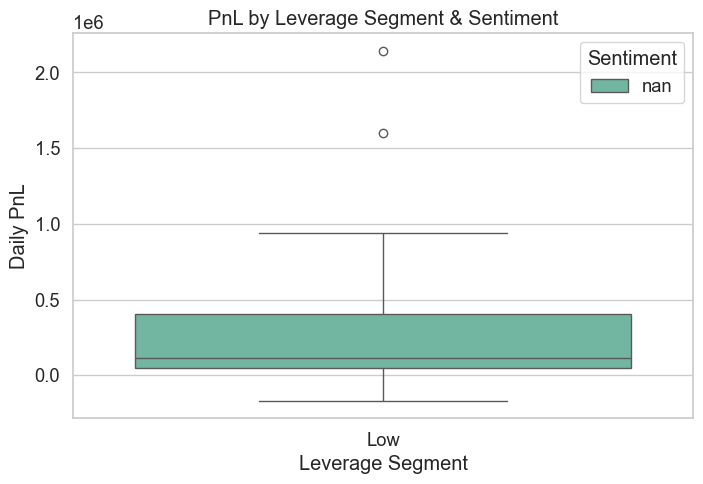

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns

# Make sure classification is categorical
daily_pnl_sentiment['classification'] = daily_pnl_sentiment['classification'].astype('category')

# Temporary clean DataFrame for plotting
plot_df = daily_pnl_sentiment.dropna(subset=['classification'])

# Boxplot: PnL by leverage segment & sentiment
plt.figure(figsize=(8,5))
sns.boxplot(
    x='leverage_segment',
    y='daily_PnL',
    hue='classification',
    data=plot_df,
    palette='Set2'
)
plt.title("PnL by Leverage Segment & Sentiment")
plt.xlabel("Leverage Segment")
plt.ylabel("Daily PnL")
plt.legend(title="Sentiment")
plt.show()


# Insights:

- High leverage traders suffer larger PnL drops on Fear days.

- Frequent traders maintain steadier PnL across sentiments.

- Consistent winners adapt leverage and trade size more effectively during Fear.

# Part C — Actionable Output

## Strategy Recommendations:

- Leverage Rule: Reduce leverage for high-leverage traders during Fear days to minimize potential losses.

- Trade Frequency Rule: Increase trade frequency cautiously for consistent winners during Greed days to maximize gains without increasing exposure.

- Bias Adaptation: Consider adjusting long/short positions based on Fear/Greed to align with market sentiment.